##1.安裝套件

In [ ]:
!pip install -U ckiptagger\[tf,gdown\]
!pip install wordcloud SnowNLP

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 17.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for SnowNLP: filename=snownlp-0.12.3-py3-none-any.whl size=37760946 sha256=b74a028eb1d3e2fb02a4ec7cb8aaca5d01eb1b5ac3a019753e8b8c310385266f
  Stored in directory: /root/.cache/pip/wheels/43/f3/70/8990fc249efeb396007766676706f71dd3d1ca3c023ce522ce
Successfully built SnowNLP


In [ ]:
from ckiptagger import data_utils, construct_dictionary, WS, POS, NER
from wordcloud import WordCloud
from snownlp import SnowNLP
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import time
import re
import datetime

##2. 資料前處理

In [ ]:
## 讀取文章
df = pd.read_csv('ptt_ai_221130to240531 (1).csv')
df["artDate"] = pd.to_datetime(df["artDate"])
df['artDate'] = df['artDate'].dt.date

clear_df = df.copy()

#去除本次不會用到的欄位
drop_cols = ['artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate', 'dataSource']
clear_df.drop(drop_cols, axis = 1, inplace = True)

#去除文章內容為空值的筆數
clear_df.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)

#新增['sentence']欄位，用'。'取代'\n\n'，並移除'\n'
clear_df['sentence'] = clear_df['artContent'].str.replace(r'\n\n','。', regex=True)
clear_df['sentence'] = clear_df['sentence'].str.replace(r'\n','', regex=True)

#移除內文中的網址
clear_df['sentence'] = clear_df['sentence'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

clear_df['sentence'] = clear_df['sentence'].str.split("[,，。！!？?]{1,}")

sent_df = clear_df.explode('sentence').reset_index(drop=True)

#去除句子中除了字母、數字、空白字符以外的符號
sent_df['sentence'] = sent_df['sentence'].str.replace(r'[^\w\s]+|[\d]', '', regex=True).astype(str)

# 把長度小於1的sentence刪掉
sent_df = sent_df[sent_df["sentence"].str.len() > 1]

sent_df

,system_id,artUrl,artTitle,artDate,artContent,sentence
0,1,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15,【實習】\n【公司名稱】Influx FinTech 普匯金融科技\n\n【工作職缺】Fin...,實習公司名稱Influx FinTech 普匯金融科技
1,1,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15,【實習】\n【公司名稱】Influx FinTech 普匯金融科技\n\n【工作職缺】Fin...,工作職缺Fintech Marketing Intern Fiance Intern徵求條件...
2,1,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15,【實習】\n【公司名稱】Influx FinTech 普匯金融科技\n\n【工作職缺】Fin...,對國內外金融科技趨勢議題有興趣熟悉 Office 軟體社群軟體
3,1,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15,【實習】\n【公司名稱】Influx FinTech 普匯金融科技\n\n【工作職缺】Fin...,具圖文影音創作能力者額外加分具 Adobe illustrator Adobe Photo...
4,1,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15,【實習】\n【公司名稱】Influx FinTech 普匯金融科技\n\n【工作職缺】Fin...,薪資待遇實習元hr連絡方式投遞履歷工作地點台北市中山區松江路號樓之工作時間一週三天可議 午休...
...,...,...,...,...,...,...
117127,2172,https://www.ptt.cc/bbs/Tech_Job/M.1717128803.A...,[新聞]用矽類比人腦，進度條走到了1/80,2024-05-31,用矽類比人腦，進度條走到了1/80\n夢晨\nhttps://www.qbitai.com/...,神經擬態系統確實不會追求高頻率
117128,2172,https://www.ptt.cc/bbs/Tech_Job/M.1717128803.A...,[新聞]用矽類比人腦，進度條走到了1/80,2024-05-31,用矽類比人腦，進度條走到了1/80\n夢晨\nhttps://www.qbitai.com/...,還開了一個小玩笑
117129,2172,https://www.ptt.cc/bbs/Tech_Job/M.1717128803.A...,[新聞]用矽類比人腦，進度條走到了1/80,2024-05-31,用矽類比人腦，進度條走到了1/80\n夢晨\nhttps://www.qbitai.com/...,人腦就不會以很高的頻率工作
117130,2172,https://www.ptt.cc/bbs/Tech_Job/M.1717128803.A...,[新聞]用矽類比人腦，進度條走到了1/80,2024-05-31,用矽類比人腦，進度條走到了1/80\n夢晨\nhttps://www.qbitai.com/...,不然會發熱冒煙


In [ ]:
df.dropna(subset=['artContent'], inplace=True)

下面找出「AI」相關文章，與後續情緒分析一起做探索

In [ ]:
keyword_list = ['AI']
ai_selected = df[df['artContent'].str.contains('|'.join(keyword_list),regex=True)]
print(f"{' '.join(keyword_list)}：{ai_selected.shape[0]}篇相關貼文")
ai_selected.head()

AI：1645篇相關貼文


,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15,ggglu,Finance,【實習】\n【公司名稱】Influx FinTech 普匯金融科技\n\n【工作職缺】Fin...,"[{""cmtStatus"": ""噓"", ""cmtPoster"": ""cow38"", ""cmt...",118.168.142.101,2022-02-16 00:12:45,ptt
1,2,https://www.ptt.cc/bbs/Finance/M.1653071365.A....,[新聞]台銀「三駕馬車」戰略發威前4月,2022-05-21,make1302,Finance,（中央社記者張璦台北20日電）台灣銀行消金、企金、政府部門業務「三駕馬車」再發威\n，董事長...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""DerLuna"", ""c...",118.171.234.47,2022-05-22 01:11:41,ptt
3,4,https://www.ptt.cc/bbs/Finance/M.1698684536.A....,[新聞]證交所徵才開創數位驅動時代報名至11/17,2023-10-31,BangBang5566,Finance,證交所徵才開創數位驅動時代 報名至11/17止\n\n中央社\n2023年10月30日 週一...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""Laviathan"", ...",42.70.143.5,2023-10-31 01:10:55,ptt
10,11,https://www.ptt.cc/bbs/job/M.1643345697.A.98B....,[新竹]清華大學BIICLab/社群內容行銷專員,2022-01-28,lin8399,job,job版禁止張貼違反「\n就業服務法\n」、\n「\n性別平等工作法\n」、\n「\n勞基法...,[],140.114.84.173,2022-01-31 00:54:31,ptt
12,13,https://www.ptt.cc/bbs/job/M.1643360390.A.1A8....,[新竹]清華大學BIICLab/AI專案助理,2022-01-28,lin8399,job,job版禁止張貼違反「就業服務法」、「性別平等工作法」、「勞基法」與其他法律之文\n章\n發...,[],140.114.84.173,2022-01-31 00:54:31,ptt


## 3. 利用SnowNLP進行情緒分析

In [ ]:
sentiment_date = pd.merge(sent_df,ai_selected[['system_id','artDate','dataSource']],on='system_id',how='left').dropna()

def get_sentiment(sent):
    s = SnowNLP(sent)
    return s.sentiments

# 幫每句話加上情緒分數
sentiment_date['sentimentValue'] = sentiment_date.apply(lambda row : get_sentiment(row['sentence'],), axis = 1)
sentiment_date.head(3)

,system_id,artUrl,artTitle,artDate_x,artContent,sentence,artDate_y,dataSource,sentimentValue
0,1,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15,【實習】\n【公司名稱】Influx FinTech 普匯金融科技\n\n【工作職缺】Fin...,實習公司名稱Influx FinTech 普匯金融科技,2022-02-15,ptt,0.999781
1,1,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15,【實習】\n【公司名稱】Influx FinTech 普匯金融科技\n\n【工作職缺】Fin...,工作職缺Fintech Marketing Intern Fiance Intern徵求條件...,2022-02-15,ptt,0.504271
2,1,https://www.ptt.cc/bbs/Finance/M.1644917373.A....,[徵才]普匯金融科技-金融科技行銷/金融實習生,2022-02-15,【實習】\n【公司名稱】Influx FinTech 普匯金融科技\n\n【工作職缺】Fin...,對國內外金融科技趨勢議題有興趣熟悉 Office 軟體社群軟體,2022-02-15,ptt,0.056680


<Axes: >

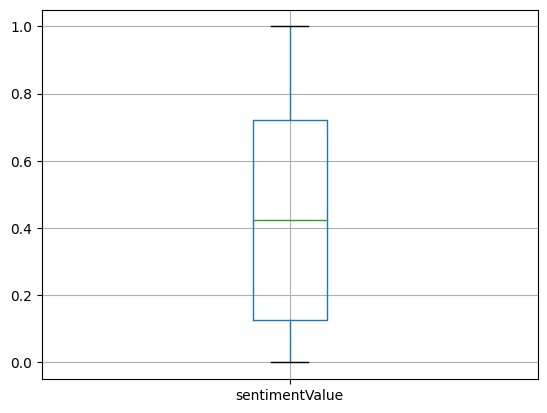

In [ ]:
# 情緒分布的盒狀圖
boxplot = sentiment_date.boxplot(column=['sentimentValue'], showfliers=False)
boxplot

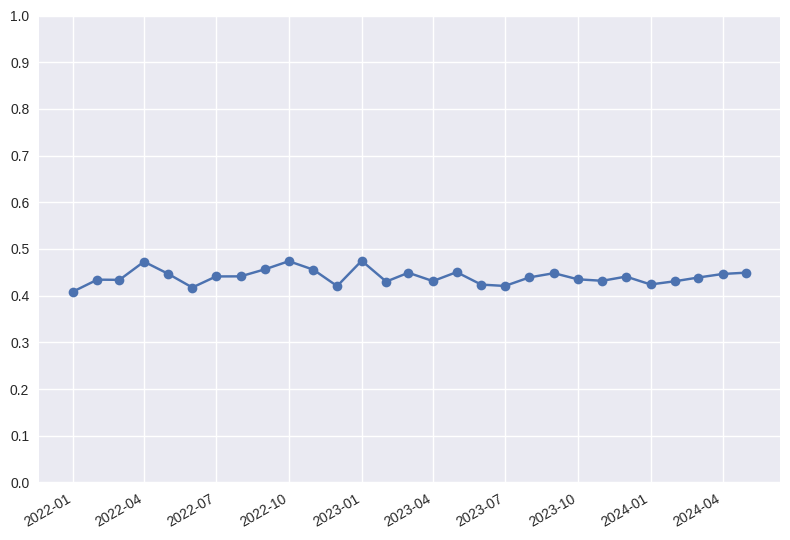

In [ ]:
sent_date = sentiment_date.copy()
sent_date['artDate'] =  pd.to_datetime(sentiment_date['artDate_x']).dt.to_period('M')

sentiment_count = sent_date.groupby(['artDate'])['sentimentValue'].mean().reset_index()

# 平均情緒分數時間趨勢
months = [period.to_timestamp() for period in sentiment_count['artDate']]   # 將 PeriodIndex 中的每個 Period 物件轉換為對應的 datetime 物件
y = sentiment_count['sentimentValue']

plt.style.use('seaborn-v0_8')

plt.plot_date(months, y, linestyle='solid')
plt.gcf().autofmt_xdate()
# 設定 y 軸刻度
plt.yticks([i/10 for i in range(11)])  # 將 y 軸刻度設定為 0 到 1，每隔 0.1 一個間隔
plt.tight_layout()
plt.ylim(0, 1)

plt.show()

In [ ]:
# 篩時間
filter_sentiment = sent_date[sent_date['artDate']=='2022-06']
filter_sentiment = filter_sentiment.loc[filter_sentiment['sentimentValue'] < 0.48]

filter_sentiment.head()

,system_id,artUrl,artTitle,artDate_x,artContent,sentence,artDate_y,dataSource,sentimentValue,artDate
5077,105,https://www.ptt.cc/bbs/part-time/M.1654056107....,[一般]植物病蟲害防治助手(工讀),2022-06-01,本人同意並願意遵守現行法律、本站使用者條款、本站各級規定、本板所有規範，\n本人願意為本文內...,本人願意為本文內容負責,2022-06-01,ptt,0.420303,2022-06
5078,105,https://www.ptt.cc/bbs/part-time/M.1654056107....,[一般]植物病蟲害防治助手(工讀),2022-06-01,本人同意並願意遵守現行法律、本站使用者條款、本站各級規定、本板所有規範，\n本人願意為本文內...,並保証本文內容皆詳盡屬實,2022-06-01,ptt,0.376177,2022-06
5080,105,https://www.ptt.cc/bbs/part-time/M.1654056107....,[一般]植物病蟲害防治助手(工讀),2022-06-01,本人同意並願意遵守現行法律、本站使用者條款、本站各級規定、本板所有規範，\n本人願意為本文內...,願受處分,2022-06-01,ptt,0.376056,2022-06
5082,105,https://www.ptt.cc/bbs/part-time/M.1654056107....,[一般]植物病蟲害防治助手(工讀),2022-06-01,本人同意並願意遵守現行法律、本站使用者條款、本站各級規定、本板所有規範，\n本人願意為本文內...,未經同意不得轉載至其它網站,2022-06-01,ptt,0.023209,2022-06
5083,105,https://www.ptt.cc/bbs/part-time/M.1654056107....,[一般]植物病蟲害防治助手(工讀),2022-06-01,本人同意並願意遵守現行法律、本站使用者條款、本站各級規定、本板所有規範，\n本人願意為本文內...,否則得視情況提出告訴,2022-06-01,ptt,0.084997,2022-06
